In [1]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
import pickle
import random
from multiprocessing import Pool
import scipy.stats as ss
# import statsmodels.stats.multitest.multipletests
import statsmodels.stats.multitest as smm
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
data_root='/data1/APA/Paul_ALS_Data/Mapper_outs_2024/'

df = pd.read_csv(f'{data_root}2024_APANET_data/2024_APANET_All_data.csv', index_col=0)

In [3]:
tmp = df[['celltype', 'condition', 'sequence','switch_name']]
tmp.to_csv('ct_cnd_apa_seqs.csv', index=False)

tmp.head()

In [4]:
pivot_df = df.pivot_table(index=['switch_name', 'celltype'], columns='condition', values='LFC_rand_INT', aggfunc='mean').dropna()
shared_APA = {}
correlations = {}
p_vals = {}
for celltype in pivot_df.index.get_level_values('celltype').unique():
    c9 = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['C9ALS']
    sALS = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['sALS']
    print(ss.pearsonr(c9, sALS))
    correlations[celltype] = ss.pearsonr(c9, sALS)[0]
    p_vals[celltype] = ss.pearsonr(c9, sALS)[1]
    print(celltype, c9.shape)
    shared_APA[celltype] = c9.shape[0]

(0.721911685323837, 6.265301546485648e-166)
Astro (1026,)
(0.8020879163321836, 0.0)
Inh (2222,)
(0.817427818655108, 3.5402366936750634e-150)
Exc_deep (620,)
(0.869889421373557, 7.244448048271233e-176)
Exc_int (568,)
(0.6549089627291347, 5.348980248424737e-159)
OPC (1291,)
(0.8387253508714428, 0.0)
Exc_upper (1386,)
(0.7247214038910368, 4.700421702617904e-200)
Oligo (1225,)
(0.6862923647852959, 7.365025629639642e-199)
Microglia (1424,)


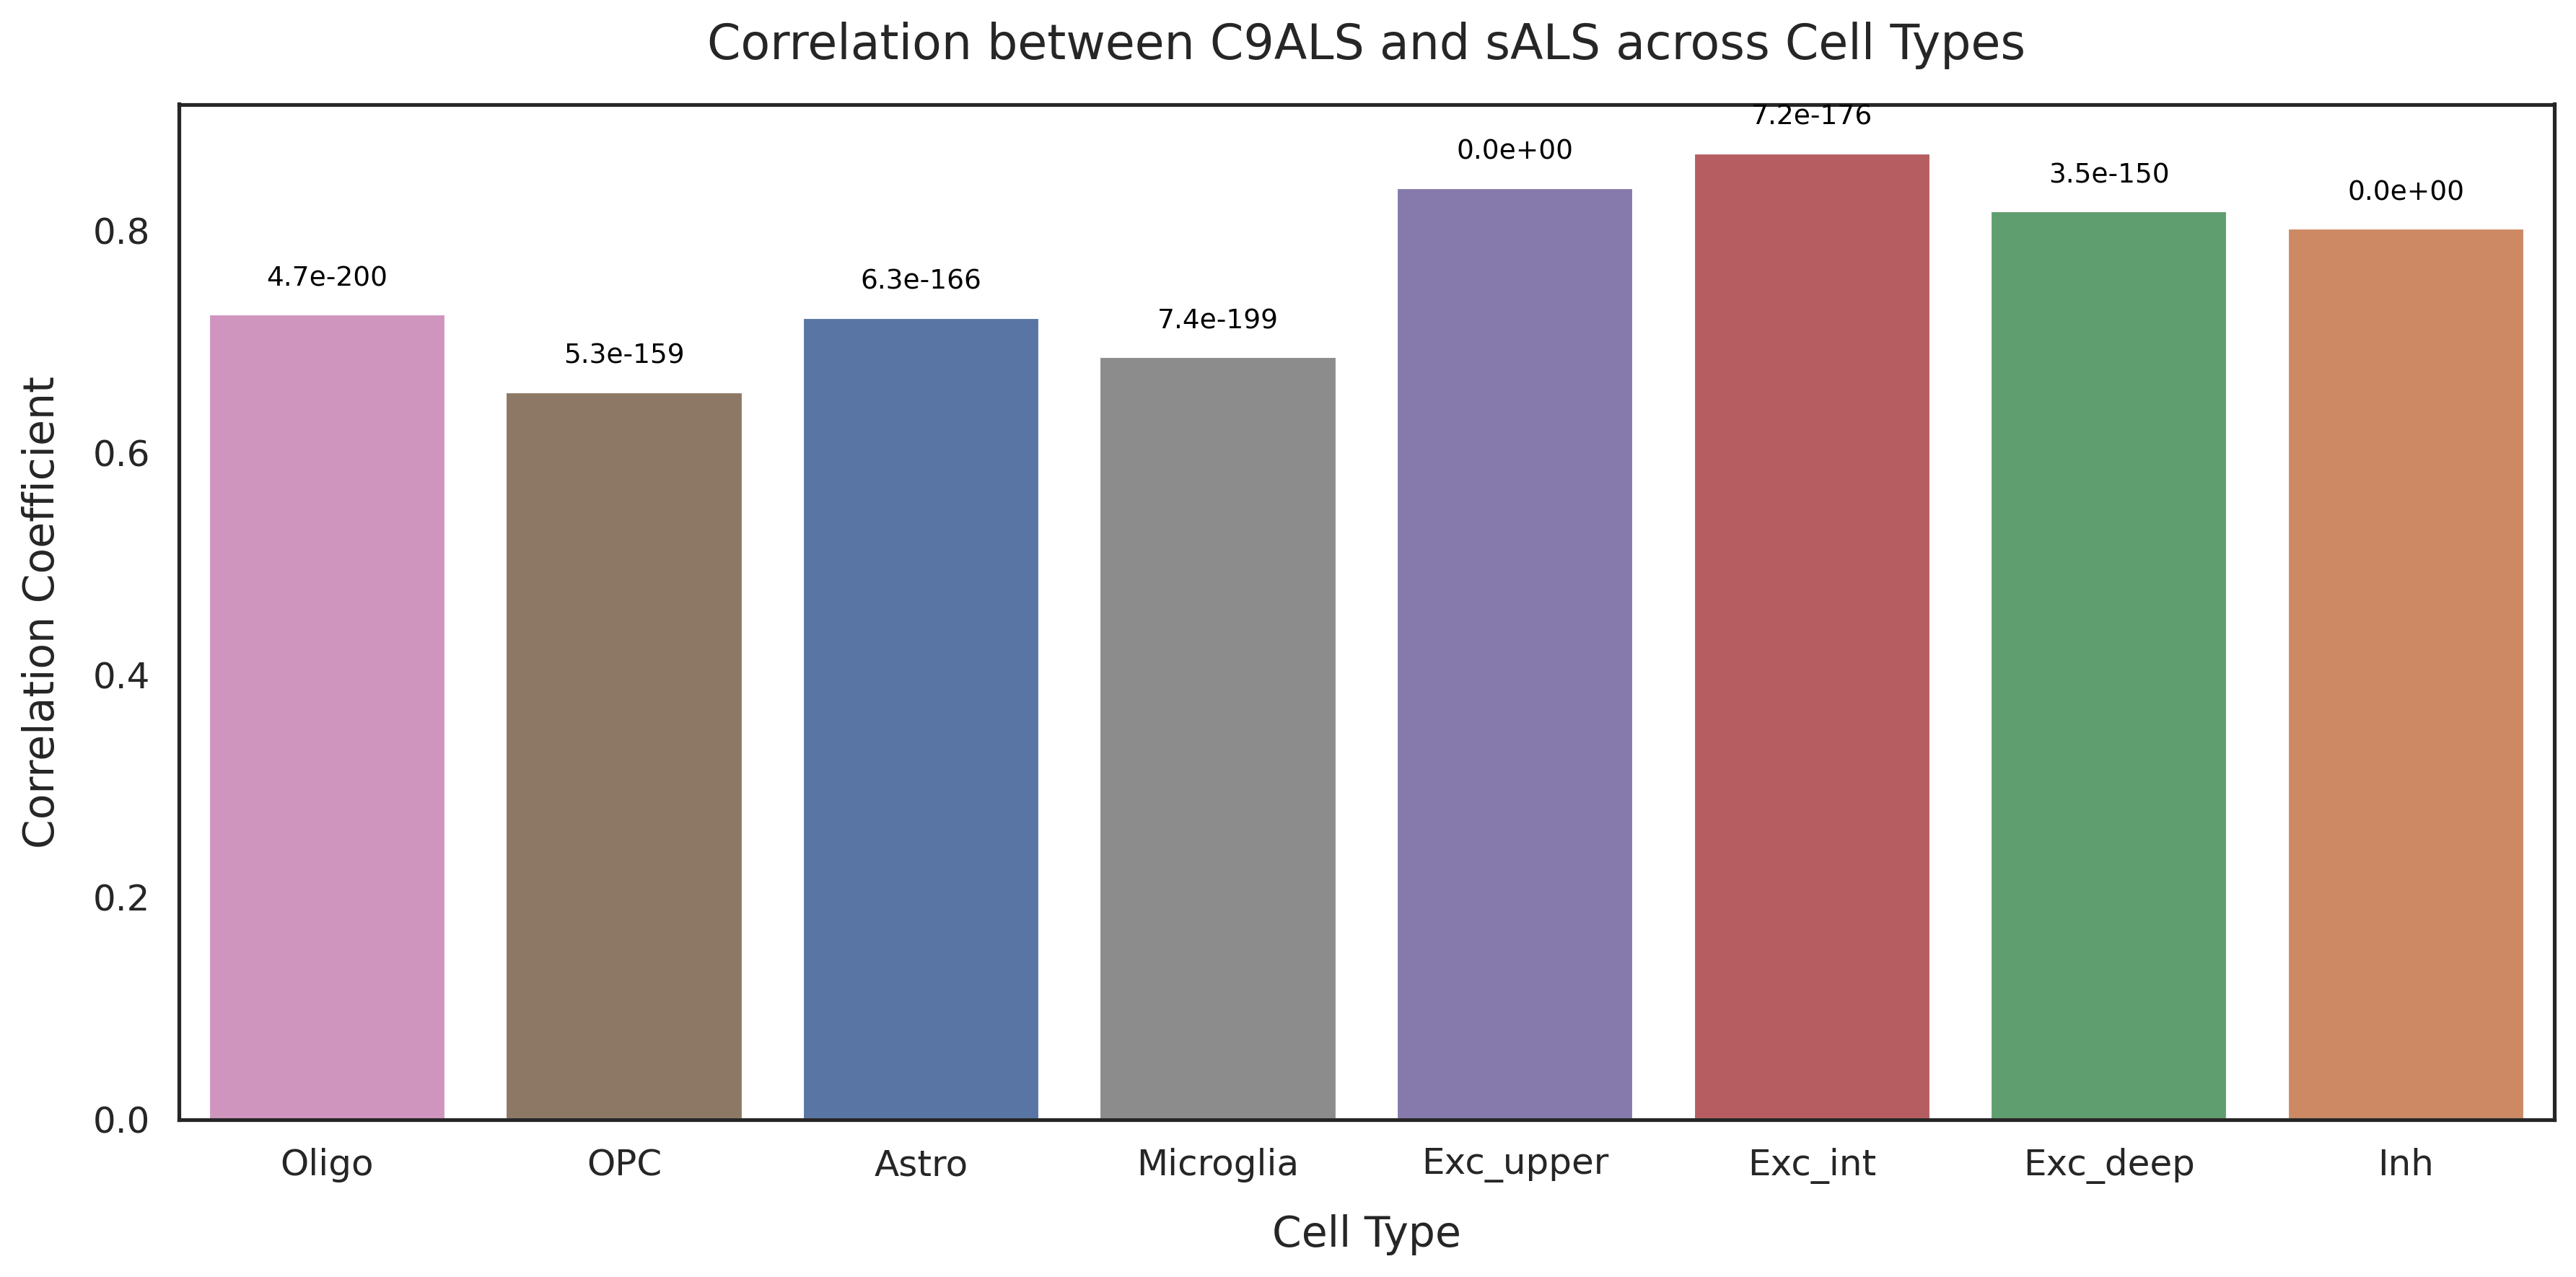

In [5]:
# Extract data for plotting
celltypes = ['Oligo','OPC','Astro','Microglia','Exc_upper','Exc_int', 'Exc_deep','Inh']
colors = ['#da8bc3', '#937860', '#4c72b0','#8c8c8c','#8172b3','#c44e52','#55a868', '#dd8452']
correlation_coefficients = [correlations[v] for v in celltypes]
p_values = [p_vals[v] for v in celltypes]

# Convert p-values to strings for display
p_value_strings = [f'{p:.1e}' for p in p_values]

# Set up the plot
sns.set(style="white")
plt.figure(figsize=(12, 6), dpi=300)

# Create bar plot
bar_plot = sns.barplot(x=celltypes, y=correlation_coefficients, palette=colors)

# Add p-values on top of the bars
for i, (correlation, pval) in enumerate(zip(correlation_coefficients, p_value_strings)):
    bar_plot.text(i, correlation + 0.02, pval, ha='center', va='bottom', fontsize=9, color='black')

# Label the axes and set title
plt.xlabel('Cell Type', fontsize=14, labelpad=10)
plt.ylabel('Correlation Coefficient', fontsize=14, labelpad=10)
plt.title('Correlation between C9ALS and sALS across Cell Types', fontsize=16, pad=15)

# Improve tick parameters for both axes
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.savefig('sALS_C9ALS_apa_correlation.pdf', format='pdf')
# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()


In [6]:
df_sALS = df[df['condition'] == 'sALS']
df_C9ALS = df[df['condition'] == 'C9ALS']

In [7]:
# Function to find unique switch names for each condition in each cell type
def find_unique_switches(df_condition1, df_condition2, condition1, condition2):
    unique_switches = {}
    celltypes = df_condition1['celltype'].unique()
    for celltype in celltypes:
        switches_condition1 = set(df_condition1[df_condition1['celltype'] == celltype]['switch_name'])
        switches_condition2 = set(df_condition2[df_condition2['celltype'] == celltype]['switch_name'])
        unique_switches[celltype] = switches_condition1 - switches_condition2
    return unique_switches

# Find unique switch names
unique_to_C9ALS = find_unique_switches(df_C9ALS, df_sALS, 'C9ALS', 'sALS')
unique_to_sALS = find_unique_switches(df_sALS, df_C9ALS, 'sALS', 'C9ALS')

## celltype vs celltype correlation

In [8]:
c9_df = df[df['condition'] == 'C9ALS']
sALS_df = df[df['condition'] == 'sALS']

In [9]:
celltypes = ['Oligo', 'OPC', 'Astro', 'Microglia', 'Exc_deep','Exc_upper', 'Exc_int','Inh']
ct_apa_dict = {}
unique_switch_names = {i:0 for i in set(c9_df['switch_name'])}
# create a map of ct to switch names, and zero the ones that celltype doesn't have
for ct in celltypes:
    ct_apa_dict[ct] = unique_switch_names.copy()
    for switch_name in unique_switch_names:
        # get APA value
        try:
            ct_apa_dict[ct][switch_name] = c9_df[(c9_df['switch_name']==switch_name) & (c9_df['celltype']==ct)]['LFC_rand_INT'].values[0]
        except:
            continue
# create a dataframe from the dictionary
df_unique_to_C9ALS = pd.DataFrame.from_dict(ct_apa_dict)
df_unique_to_C9ALS.head()

,Oligo,OPC,Astro,Microglia,Exc_deep,Exc_upper,Exc_int,Inh
chr15:SPATA5L1:45420026:45421359:+,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,-0.100585
chr11:ST5:8715463:8729950:-,0.0,-1.375274,0.000000,0.0,0.000000,0.0,0.000000,-0.640343
chr7:RHBDD2:75882216:75888444:+,0.0,0.000000,-1.699896,0.0,0.000000,0.0,-0.074677,0.000000
chr19:ZNF586:57781586:57800592:+,0.0,0.000000,0.000000,0.0,-1.608434,0.0,0.000000,0.000000
chr2:IRS1:226735048:226793073:-,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.145102,0.000000


In [13]:
pivot_df = df.pivot_table(index=['switch_name', 'celltype'], columns='condition', values='LFC_rand_INT', aggfunc='mean').fillna(0)
unique_apas = {}
correlations2 = {}
p_vals2 = {}
for celltype in pivot_df.index.get_level_values('celltype').unique():
    c9 = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['C9ALS']
    sALS = pivot_df.loc[pivot_df.index.get_level_values('celltype') == celltype]['sALS']
    print(ss.pearsonr(c9, sALS), c9.shape, sALS.shape)
    correlations2[celltype] = ss.pearsonr(c9, sALS)[0]
    p_vals2[celltype] = ss.pearsonr(c9, sALS)[1]
    print(celltype, c9.shape)
    unique_apas[celltype] = c9.shape[0]

(0.23209207380078895, 1.7397788509103608e-55) (4449,) (4449,)
Exc_int (4449,)
(0.2828744735750356, 4.0574938447939854e-120) (6514,) (6514,)
Exc_upper (6514,)
(0.2503885573600605, 4.7198175632496264e-77) (5334,) (5334,)
Oligo (5334,)
(0.23143131043441084, 2.515086803734003e-72) (5879,) (5879,)
Astro (5879,)
(0.19773760162004494, 8.050108291188385e-57) (6329,) (6329,)
OPC (6329,)
(0.370682202772049, 1.7541290469954603e-233) (7204,) (7204,)
Inh (7204,)
(0.19036662685015432, 2.824563661084864e-41) (4908,) (4908,)
Exc_deep (4908,)
(0.21568934703723658, 3.589972993670615e-77) (7260,) (7260,)
Microglia (7260,)


In [14]:
# table with shared and unique apas
shared_unique_df = pd.DataFrame([shared_APA, unique_apas], index=['shared', 'All']).T

shared_unique_df['unique'] = shared_unique_df['All'] - shared_unique_df['shared']
shared_unique_df



,shared,All,unique
Astro,1026,5879,4853
Inh,2222,7204,4982
Exc_deep,620,4908,4288
Exc_int,568,4449,3881
OPC,1291,6329,5038
Exc_upper,1386,6514,5128
Oligo,1225,5334,4109
Microglia,1424,7260,5836


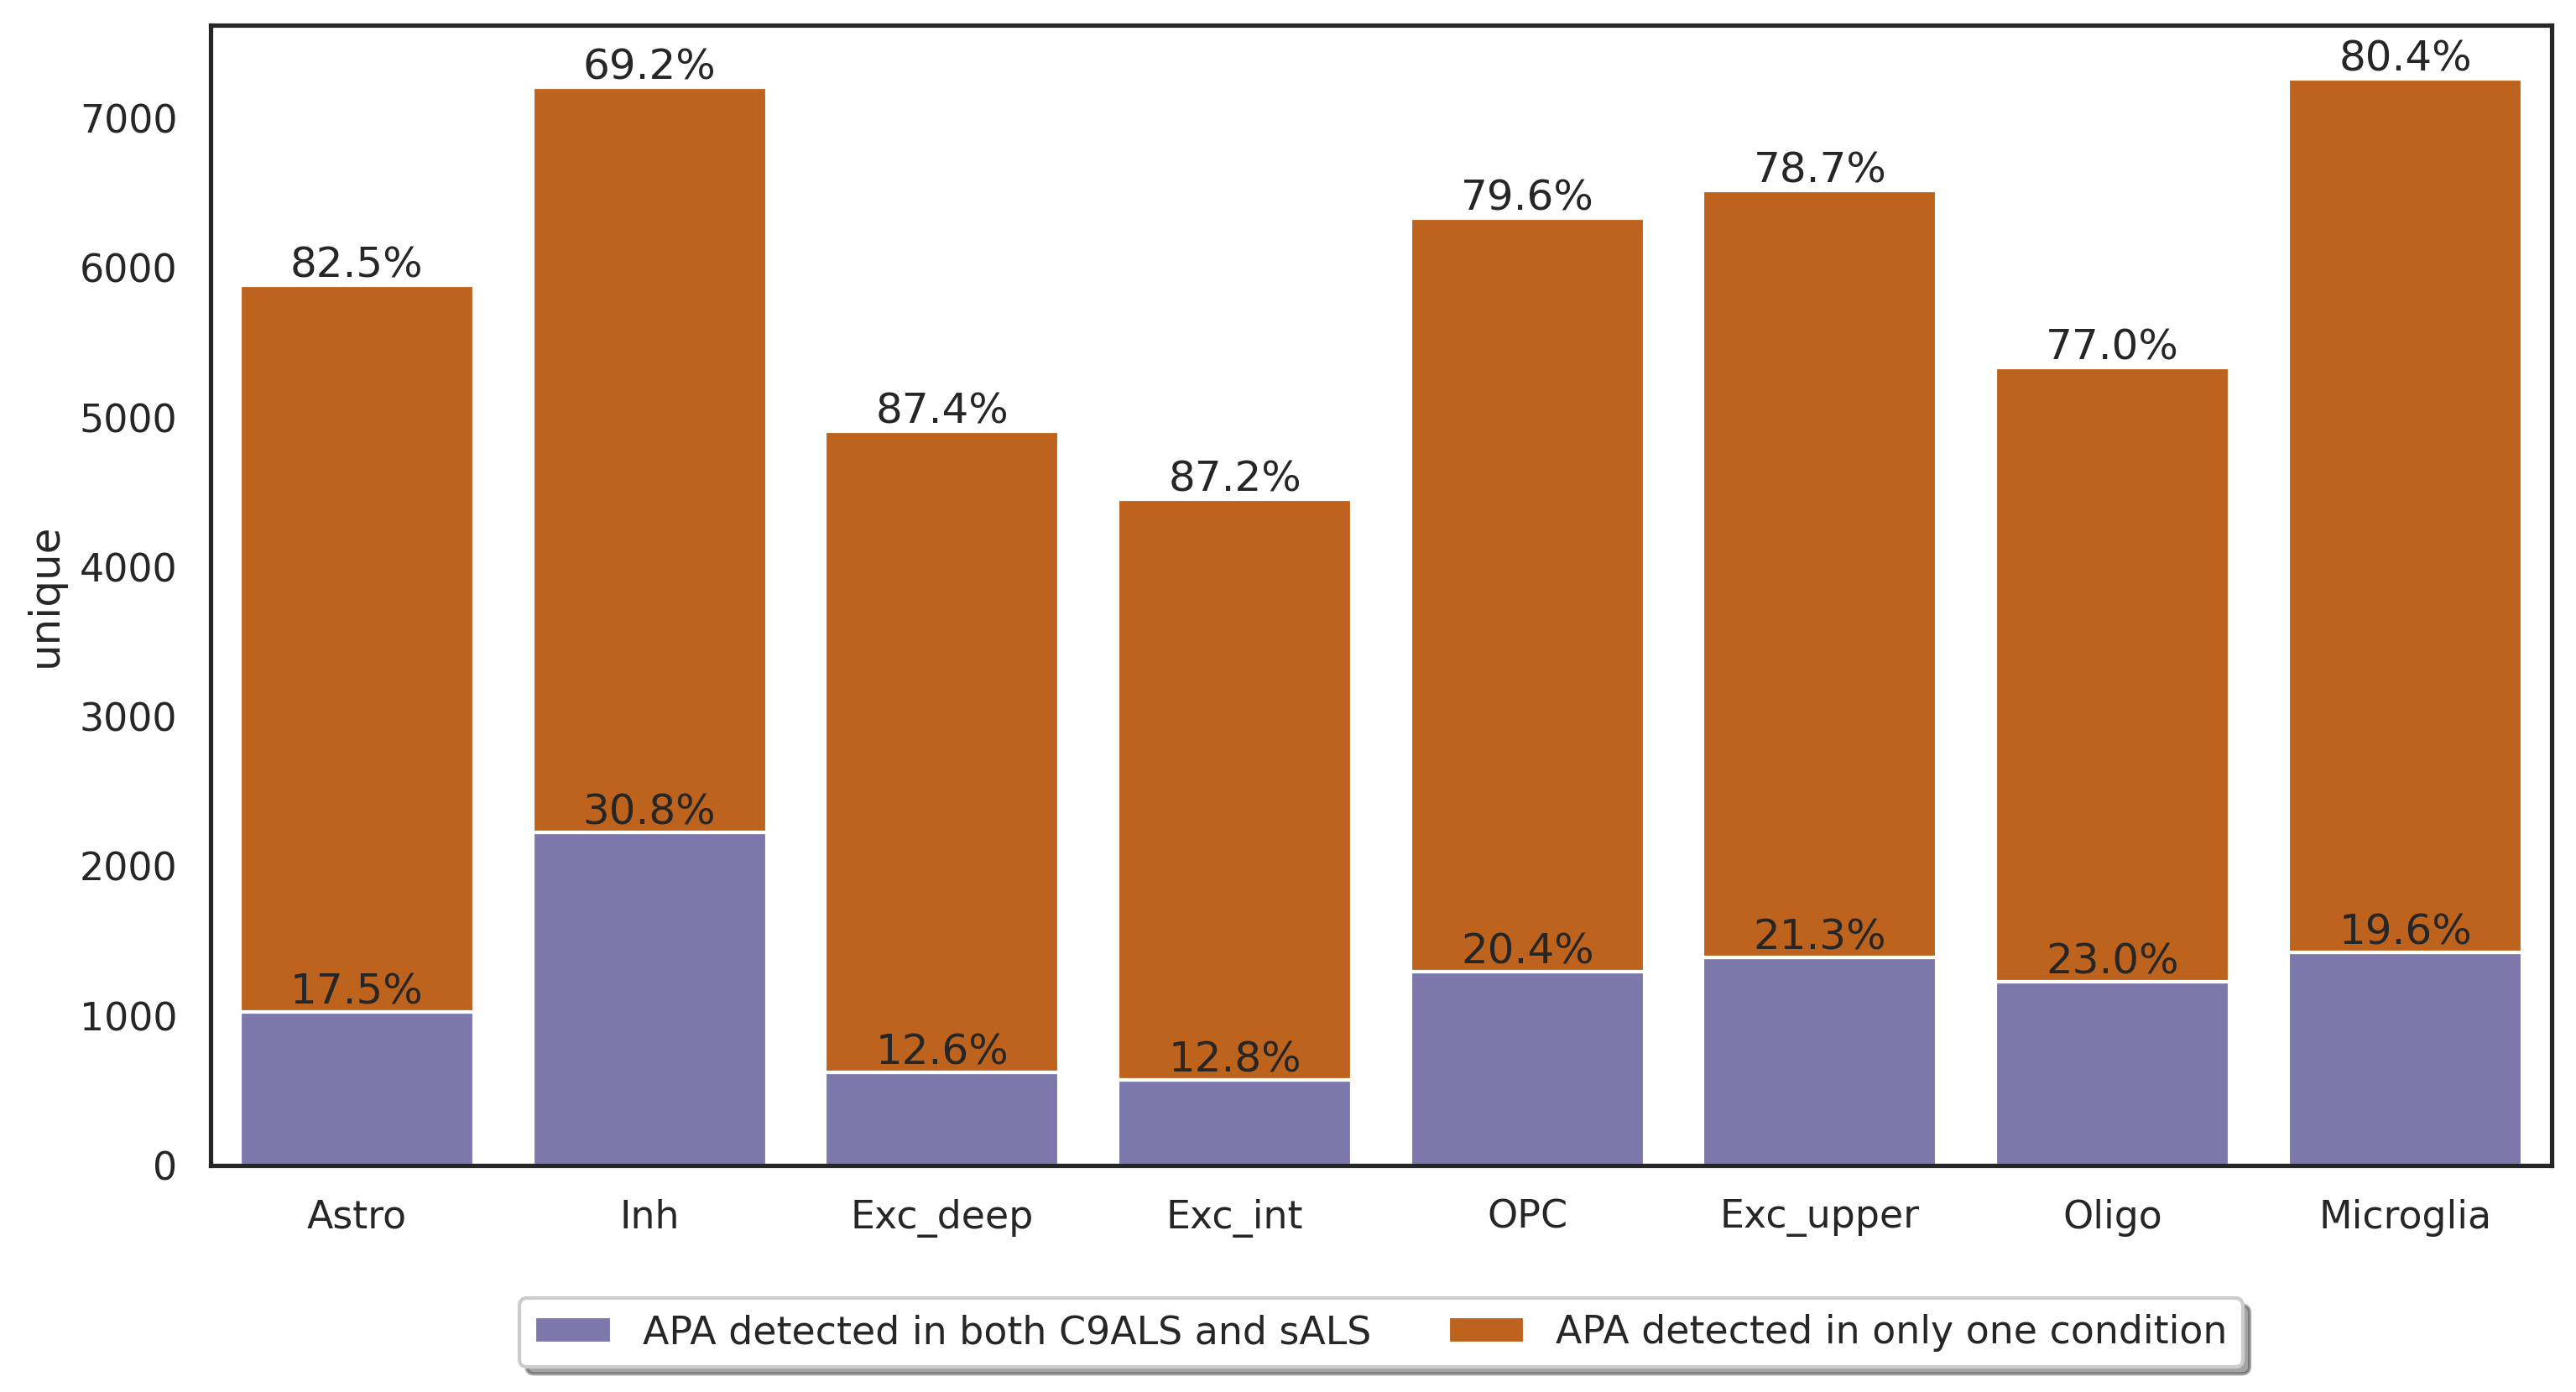

In [16]:
sns.set(style="white")
plt.figure(figsize=(12, 6), dpi=300)

# Calculate percentages
shared_percentage = (shared_unique_df['shared'] / shared_unique_df['All']) * 100
unique_percentage = (shared_unique_df['unique'] / shared_unique_df['All']) * 100

# Plot bars
bar1 = sns.barplot(x=shared_unique_df.index, y=shared_unique_df['shared'], color='#7570b3', label='APA detected in both C9ALS and sALS')
bar2 = sns.barplot(x=shared_unique_df.index, y=shared_unique_df['unique'], bottom=shared_unique_df['shared'], color='#d95f02', label='APA detected in only one condition')

# Add percentages on top of the bars
for index, value in enumerate(shared_unique_df['shared']):
    plt.text(index, value, f'{shared_percentage[index]:.1f}%', ha='center', va='bottom')

for index, (shared_value, unique_value) in enumerate(zip(shared_unique_df['shared'], shared_unique_df['unique'])):
    plt.text(index, shared_value + unique_value, f'{unique_percentage[index]:.1f}%', ha='center', va='bottom')

# put legend outside of the figure under the x-axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
# save pdf
plt.savefig('C9_sALS_shared_unique_apa.pdf', format='pdf')
plt.show()

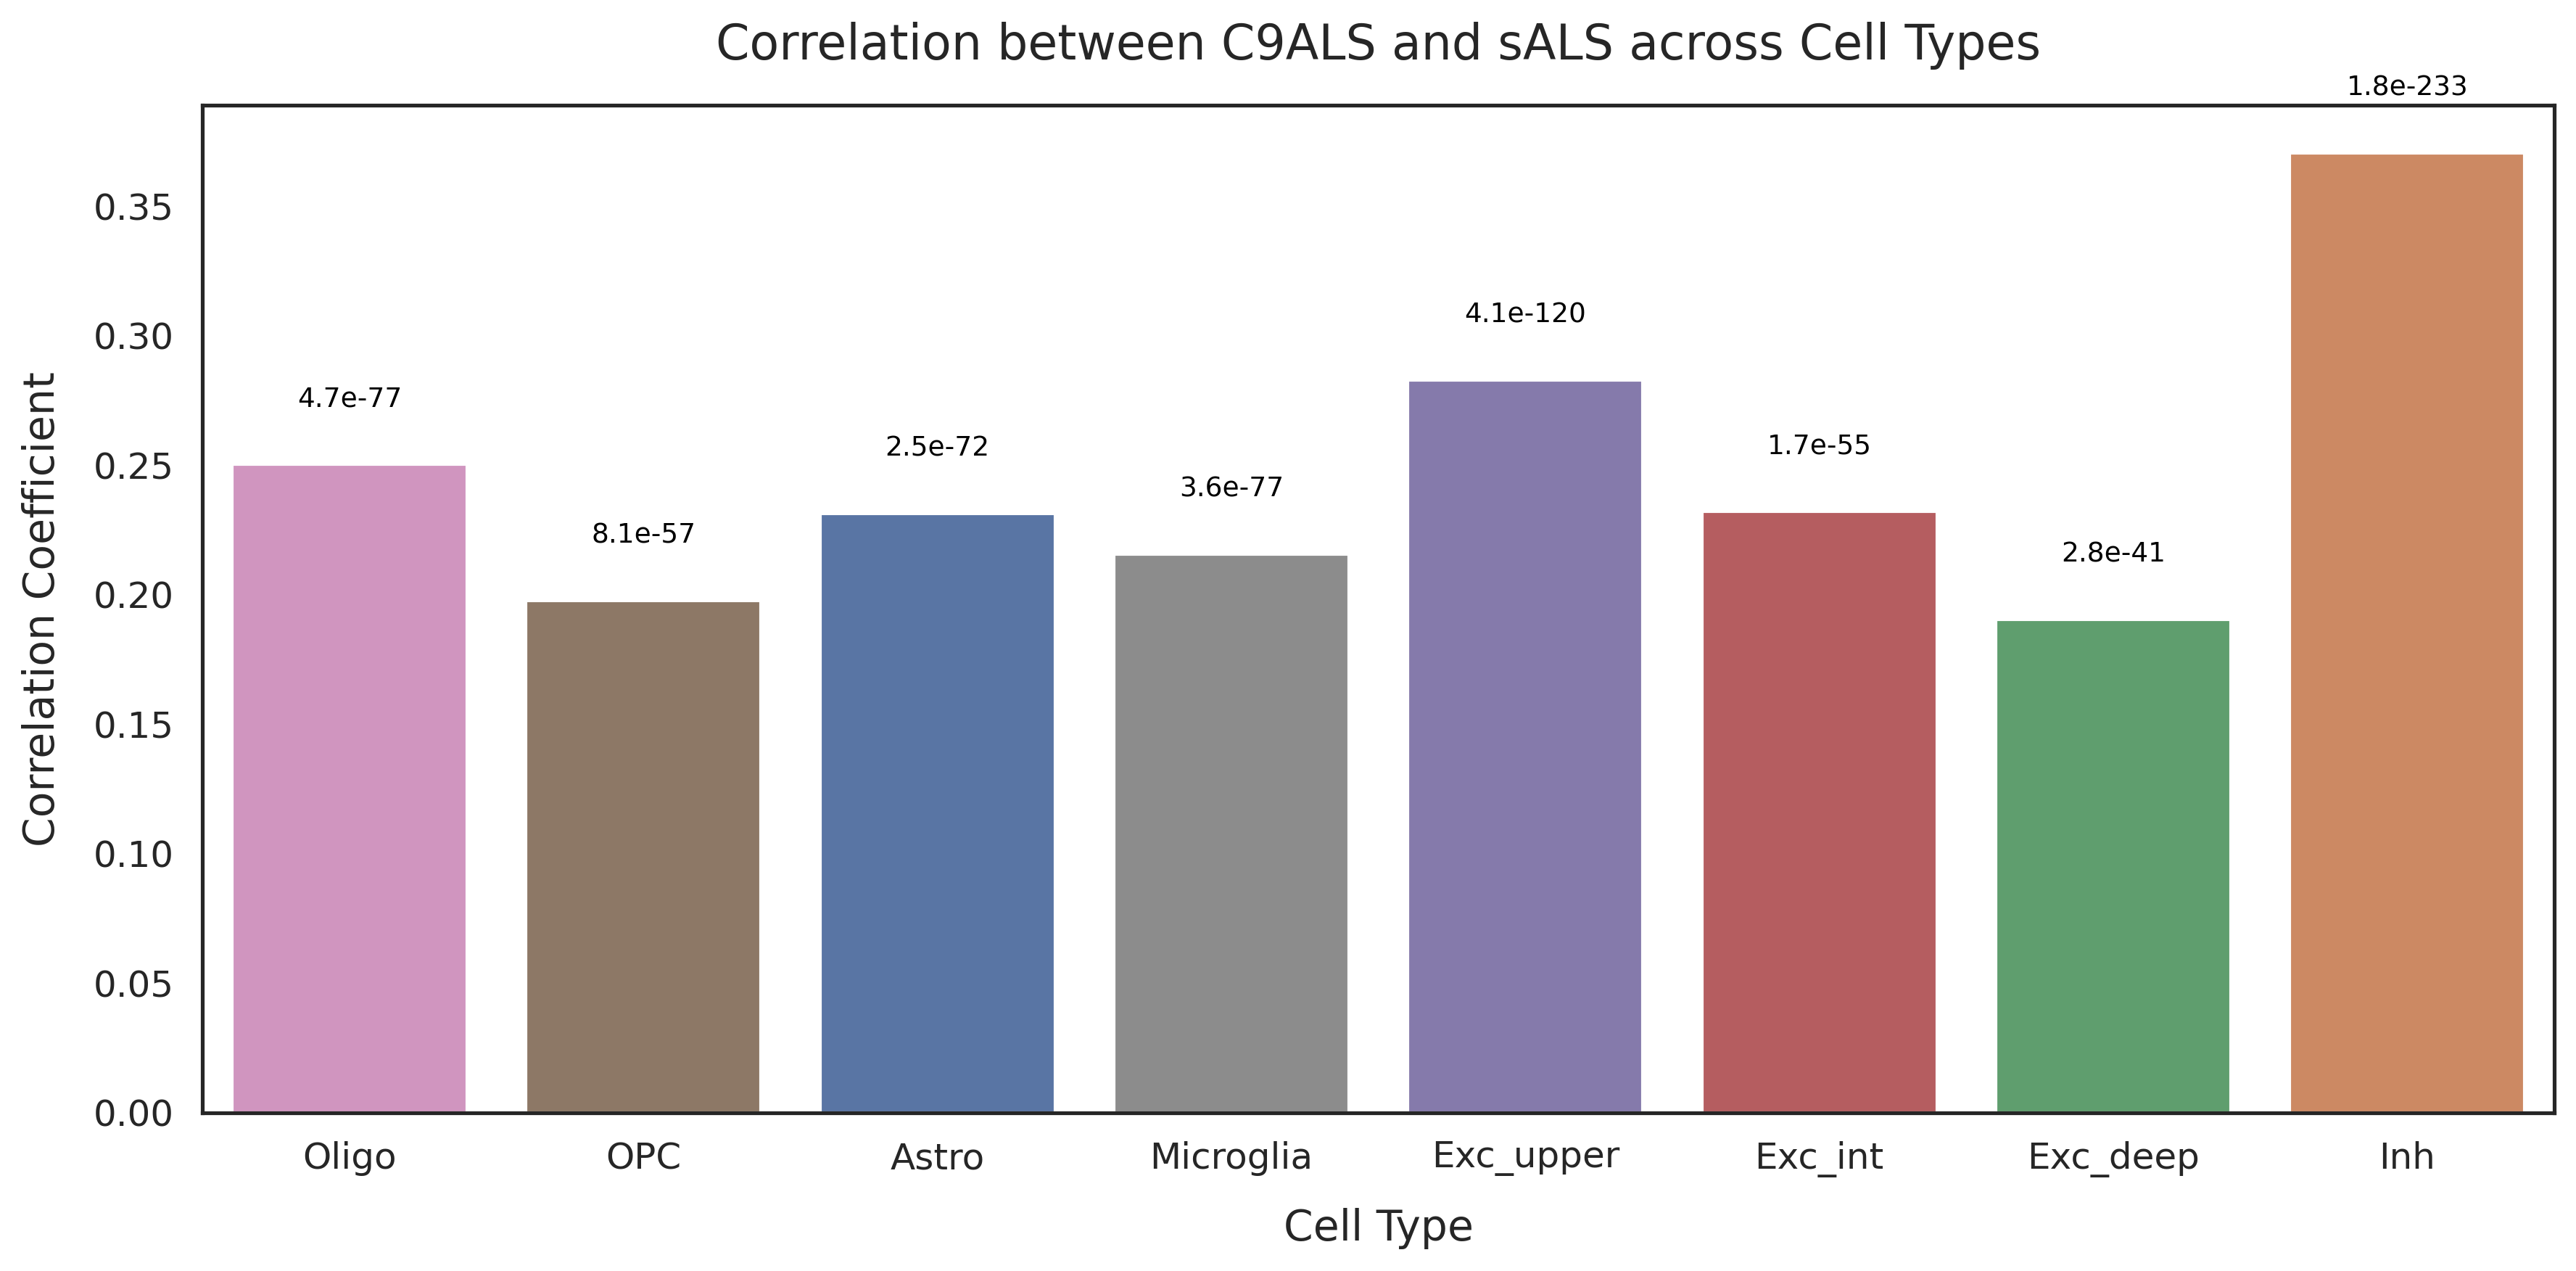

In [16]:
# Extract data for plotting
celltypes = ['Oligo','OPC','Astro','Microglia','Exc_upper','Exc_int', 'Exc_deep','Inh']
colors = ['#da8bc3', '#937860', '#4c72b0','#8c8c8c','#8172b3','#c44e52','#55a868', '#dd8452']
correlation_coefficients = [correlations2[v] for v in celltypes]
p_values = [p_vals2[v] for v in celltypes]

# Convert p-values to strings for display
p_value_strings = [f'{p:.1e}' for p in p_values]

# Set up the plot
sns.set(style="white")
plt.figure(figsize=(12, 6), dpi=300)

# Create bar plot
bar_plot = sns.barplot(x=celltypes, y=correlation_coefficients, palette=colors)

# Add p-values on top of the bars
for i, (correlation, pval) in enumerate(zip(correlation_coefficients, p_value_strings)):
    bar_plot.text(i, correlation + 0.02, pval, ha='center', va='bottom', fontsize=9, color='black')

# Label the axes and set title
plt.xlabel('Cell Type', fontsize=14, labelpad=10)
plt.ylabel('Correlation Coefficient', fontsize=14, labelpad=10)
plt.title('Correlation between C9ALS and sALS across Cell Types', fontsize=16, pad=15)

# Improve tick parameters for both axes
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.savefig('sALS_C9ALS_All_apa_correlation.pdf', format='pdf')
# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()

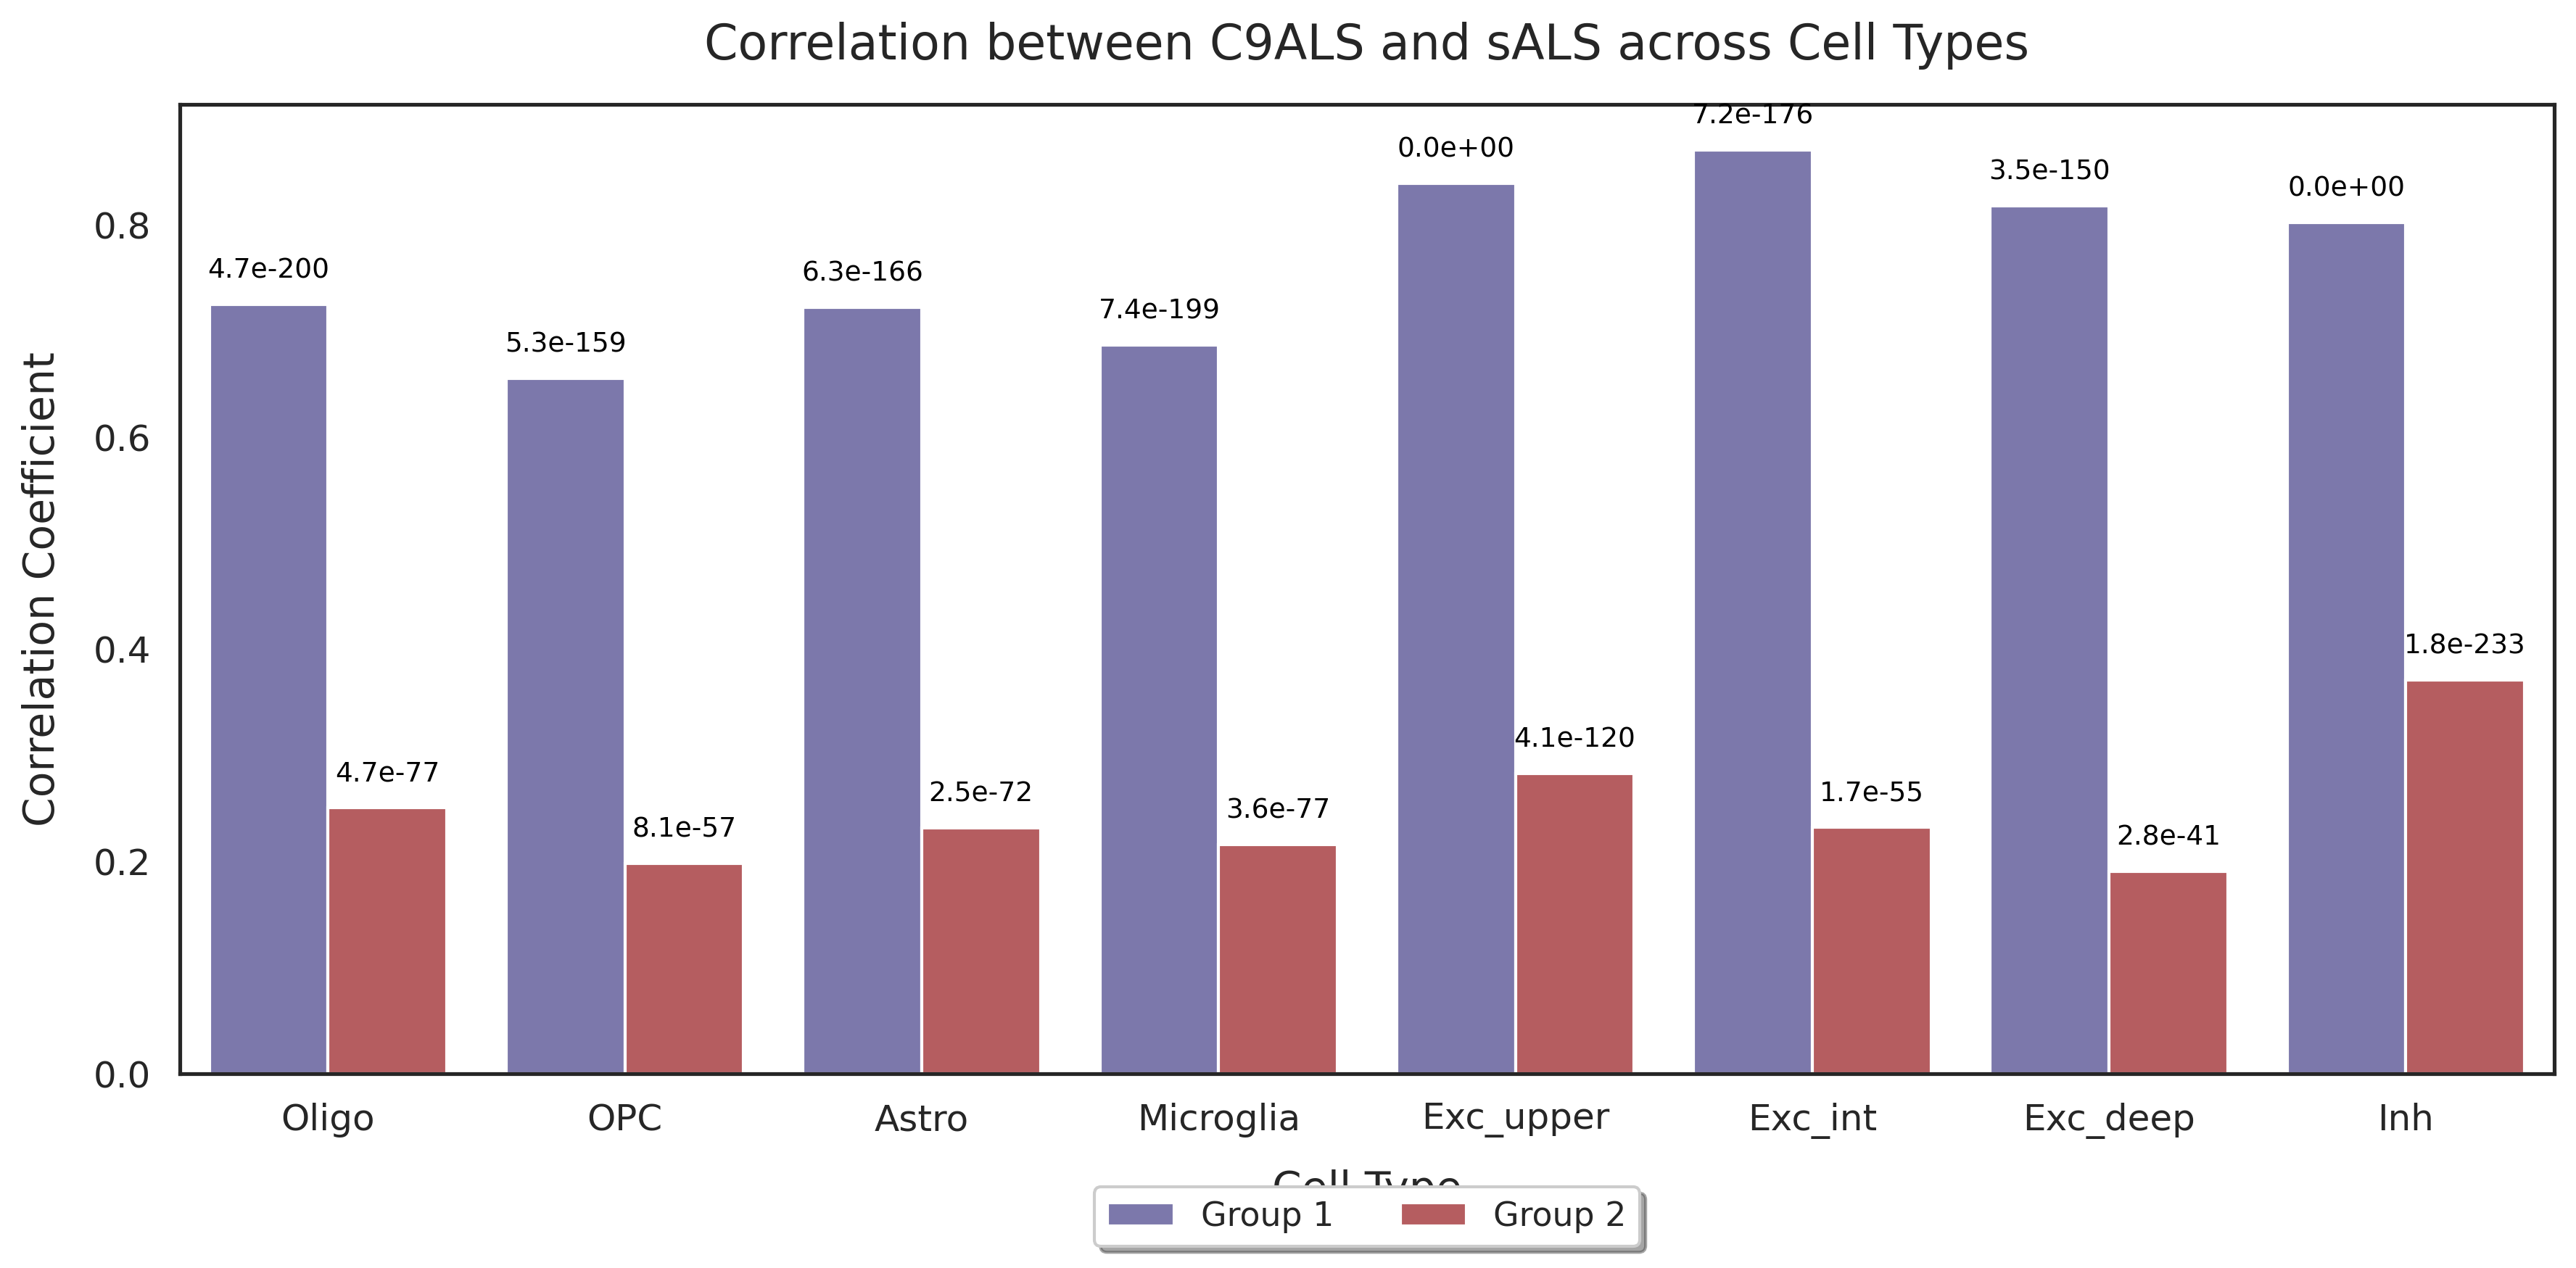

In [21]:
# Sample data (replace these with your actual dictionaries)
celltypes = ['Oligo', 'OPC', 'Astro', 'Microglia', 'Exc_upper', 'Exc_int', 'Exc_deep', 'Inh']
colors = ['#da8bc3', '#937860', '#4c72b0', '#8c8c8c', '#8172b3', '#c44e52', '#55a868', '#dd8452']

correlations1 = [correlations[v] for v in celltypes]
correlations22 = [correlations2[v] for v in celltypes]
p_values1 = [p_vals[v] for v in celltypes]
p_values2 = [p_vals2[v] for v in celltypes]

# Convert p-values to strings for display
p_value_strings1 = [f'{p:.1e}' for p in p_values1]
p_value_strings2 = [f'{p:.1e}' for p in p_values2]

# Create a DataFrame for plotting
data = {
    'Cell Type': celltypes * 2,
    'Correlation Coefficient': correlations1 + correlations22,
    'P Value': p_value_strings1 + p_value_strings2,
    'Group': ['Group 1'] * len(celltypes) + ['Group 2'] * len(celltypes)
}
df = pd.DataFrame(data)

# Set up the plot
sns.set(style="white")
plt.figure(figsize=(12, 6), dpi=300)

# Create bar plot
bar_plot = sns.barplot(x='Cell Type', y='Correlation Coefficient', hue='Group', data=df, palette=['#7570b3','#c44e52'])

# Add p-values on top of the bars
for i in range(len(celltypes)):
    bar_plot.text(i - 0.2, correlations1[i] + 0.02, p_value_strings1[i], ha='center', va='bottom', fontsize=9, color='black')
    bar_plot.text(i + 0.2, correlations22[i] + 0.02, p_value_strings2[i], ha='center', va='bottom', fontsize=9, color='black')

# Label the axes and set title
plt.xlabel('Cell Type', fontsize=14, labelpad=10)
plt.ylabel('Correlation Coefficient', fontsize=14, labelpad=10)
plt.title('Correlation between C9ALS and sALS across Cell Types', fontsize=16, pad=15)

# Improve tick parameters for both axes
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
# plt.savefig('sALS_C9ALS_All_apa_correlation.pdf', format='pdf')
# Use tight layout to ensure everything fits without overlapping
plt.tight_layout()
plt.savefig('sALS_C9ALS_All_apa_correlation.pdf', format='pdf')
plt.show()
